In [1]:
from numpy import array
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix, dok_matrix, lil_matrix
import timeit


# 62

In [2]:
# create dense matrix
A = array([[1, 0, 0, 1, 0, 0], [0, 0, 2, 0, 0, 1], [0, 0, 0, 2, 0, 0]])
print(A)

# convert to sparse matrix (COO method)
S = coo_matrix(A)
print(S)

print(S.tocsr()[:,3])

# reconstruct dense matrix
B = S.todense()
print(B)
times = 100000
print(f'{timeit.timeit(lambda : dok_matrix(B), number=times)/times=}')
print(f'{timeit.timeit(lambda : lil_matrix(B), number=times)/times=}')
print(f'{timeit.timeit(lambda : csr_matrix(B), number=times)/times=}')
print(f'{timeit.timeit(lambda : csc_matrix(B), number=times)/times=}')


[[1 0 0 1 0 0]
 [0 0 2 0 0 1]
 [0 0 0 2 0 0]]
  (0, 0)	1
  (0, 3)	1
  (1, 2)	2
  (1, 5)	1
  (2, 3)	2
  (0, 0)	1
  (2, 0)	2
[[1 0 0 1 0 0]
 [0 0 2 0 0 1]
 [0 0 0 2 0 0]]
timeit.timeit(lambda : dok_matrix(B), number=times)/times=0.00010697126045000004
timeit.timeit(lambda : lil_matrix(B), number=times)/times=0.00013936469105000468
timeit.timeit(lambda : csr_matrix(B), number=times)/times=0.00011469011701999989
timeit.timeit(lambda : csc_matrix(B), number=times)/times=0.00011148536484000033


# 64-67

In [3]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pandas as pd
from pandarallel import pandarallel
import string
import numpy as np
import timeit

pandarallel.initialize()

path = r"./resources/software_developer_united_states_1971_20191023_1.csv"


INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
def extract_description(df: pd.DataFrame):
    s = df["job_description"]
    s = s.parallel_apply(
        lambda s: s.lower()
        .translate(str.maketrans("", "", string.punctuation + "\xa0"))
        .translate(str.maketrans(string.whitespace, " " * len(string.whitespace)))
    )
    return s


def tokenize(s: pd.Series):
    return s.parallel_apply(lambda s: set(word_tokenize(s)))

def remove_stopwords(s: pd.Series):
    stopwords_set = set(stopwords.words())
    return s.parallel_apply(lambda s: s.difference(stopwords_set))

def filter_word_length(s: pd.Series, n: int):
    return s.parallel_apply(lambda s: {word for word in s if len(word) >= n})

def stem(s: pd.Series):
    ps = PorterStemmer()
    return s.parallel_apply(lambda s: {ps.stem(word) for word in s})


def transformation_pipe(df: pd.DataFrame):
    s = extract_description(df)
    s = tokenize(s)
    s = remove_stopwords(s)
    s = filter_word_length(s, 3)
    s = stem(s)
    return s


In [5]:
rows = pd.read_csv(path)[:1000]
descriptions = transformation_pipe(rows)
descriptions


0      {junior, recruit, relat, healthcar, sole, nonf...
1      {relat, grow, xml, framework, skill, enhanc, s...
2      {build, recruit, origin, framework, grunt, ec2...
3      {suggest, multin, enhanc, recommend, client, l...
4      {relat, grow, xml, framework, skill, enhanc, s...
                             ...                        
995    {563, wwwngsinfonetcom, road, month, skill, 12...
996    {origin, deploy, law, skill, thoughtlead, fit,...
997    {build, recruit, focu, date, priorit, lost, an...
998    {metadata, relat, focu, action, univers, xml, ...
999    {extern, integr, applic, consult, asset, syste...
Name: job_description, Length: 1000, dtype: object

In [6]:
from sklearn.feature_extraction.text import CountVectorizer


In [7]:
cv = CountVectorizer(analyzer=lambda x: x)
X = cv.fit_transform(descriptions)
print(pd.DataFrame(X.toarray(), columns=cv.get_feature_names_out()))


     001  007009501759972  009000010840340  010  010209501755598  \
0      0                0                0    0                0   
1      0                0                0    0                0   
2      0                0                0    0                0   
3      0                0                0    0                0   
4      0                0                0    0                0   
..   ...              ...              ...  ...              ...   
995    0                0                0    0                0   
996    0                0                0    0                0   
997    0                0                0    0                0   
998    0                0                0    0                0   
999    0                0                0    0                0   

     013000010841024  015000010801094  01581  021019  02108  ...  •the  •two  \
0                  0                0      0       0      0  ...     0     0   
1                  0   

In [8]:
XX = X.toarray()
timeit.timeit(lambda: np.matmul(XX, XX.T),number=1)


6.241772674000458

In [9]:
timeit.timeit(lambda: X*X.T,number=1)


0.07192143499923986

In [10]:
print(f"{timeit.timeit(lambda: np.matmul(XX, XX.T), number=3)/3=}")
print(f"{timeit.timeit(lambda: X.todok()*X.T.todok(),number=3)/3=}")
print(f"{timeit.timeit(lambda: X.tolil()*X.T.tolil(),number=3)/3=}")
print(f"{timeit.timeit(lambda: X.tocoo()*X.T.tocoo(),number=3)/3=}")
print(f"{timeit.timeit(lambda: X.tocsc()*X.T.tocsc(),number=3)/3=}")


timeit.timeit(lambda: np.matmul(XX, XX.T), number=3)/3=5.775204409333128
timeit.timeit(lambda: X.todok()*X.T.todok(),number=3)/3=0.20328985233330363
timeit.timeit(lambda: X.tolil()*X.T.tolil(),number=3)/3=0.08749893266667641
timeit.timeit(lambda: X.tocoo()*X.T.tocoo(),number=3)/3=0.06553518733350454
timeit.timeit(lambda: X.tocsc()*X.T.tocsc(),number=3)/3=0.06209700233315137


# 70

In [86]:
import pandas as pd
from multiprocessing import Pool


In [46]:
rows = pd.read_csv(path)
rows.drop_duplicates(inplace=True)
descriptions = extract_description(rows)
descriptions = tokenize(descriptions)


In [89]:
def set_filter(s: pd.Series):
    stopwords_set = set(stopwords.words())
    return s.apply(lambda s: s.difference(stopwords_set))

def list_filter(s: pd.Series):
    stopwords_list = stopwords.words()
    return s.apply(lambda s: [word for word in s if word not in stopwords_list])


In [90]:
sizes = list(range(0, len(rows), len(rows)//20)) + [len(rows)]
sizes.pop(0)
perf_df = pd.DataFrame(sizes[:6], columns=["size"])
perf_df


,size
0,500
1,1000
2,1500
3,2000
4,2500
5,3000


In [92]:
pool_sizes = [1, 2, 4, 8, 12]

def process(pool_size, size, func):
    print(f"{pool_size=} {size=} {func=}")
    split = np.array_split(descriptions[:size], pool_size)
    with Pool(pool_size) as p:
        p.map(func, split)

for n in pool_sizes:
    perf_df[f"set_{n}"] = perf_df["size"].apply(lambda x: timeit.timeit(lambda: process(n, x, set_filter), number=1))
    perf_df[f"list_{n}"] = perf_df["size"].apply(lambda x: timeit.timeit(lambda: process(n, x, list_filter), number=1))

perf_df


pool_size=1 size=500 func=<function set_filter at 0x7fa692c6f520>
pool_size=1 size=1000 func=<function set_filter at 0x7fa692c6f520>
pool_size=1 size=1500 func=<function set_filter at 0x7fa692c6f520>
pool_size=1 size=2000 func=<function set_filter at 0x7fa692c6f520>
pool_size=1 size=2500 func=<function set_filter at 0x7fa692c6f520>
pool_size=1 size=3000 func=<function set_filter at 0x7fa692c6f520>
pool_size=1 size=500 func=<function list_filter at 0x7fa693b93760>
pool_size=1 size=1000 func=<function list_filter at 0x7fa693b93760>
pool_size=1 size=1500 func=<function list_filter at 0x7fa693b93760>
pool_size=1 size=2000 func=<function list_filter at 0x7fa693b93760>
pool_size=1 size=2500 func=<function list_filter at 0x7fa693b93760>
pool_size=1 size=3000 func=<function list_filter at 0x7fa693b93760>
pool_size=2 size=500 func=<function set_filter at 0x7fa692c6f520>


/home/mansmooth/anaconda3/envs/se481-2023/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


pool_size=2 size=1000 func=<function set_filter at 0x7fa692c6f520>
pool_size=2 size=1500 func=<function set_filter at 0x7fa692c6f520>
pool_size=2 size=2000 func=<function set_filter at 0x7fa692c6f520>
pool_size=2 size=2500 func=<function set_filter at 0x7fa692c6f520>
pool_size=2 size=3000 func=<function set_filter at 0x7fa692c6f520>
pool_size=2 size=500 func=<function list_filter at 0x7fa693b93760>


/home/mansmooth/anaconda3/envs/se481-2023/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


pool_size=2 size=1000 func=<function list_filter at 0x7fa693b93760>
pool_size=2 size=1500 func=<function list_filter at 0x7fa693b93760>
pool_size=2 size=2000 func=<function list_filter at 0x7fa693b93760>
pool_size=2 size=2500 func=<function list_filter at 0x7fa693b93760>
pool_size=2 size=3000 func=<function list_filter at 0x7fa693b93760>
pool_size=3 size=500 func=<function set_filter at 0x7fa692c6f520>


/home/mansmooth/anaconda3/envs/se481-2023/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


pool_size=3 size=1000 func=<function set_filter at 0x7fa692c6f520>
pool_size=3 size=1500 func=<function set_filter at 0x7fa692c6f520>
pool_size=3 size=2000 func=<function set_filter at 0x7fa692c6f520>
pool_size=3 size=2500 func=<function set_filter at 0x7fa692c6f520>
pool_size=3 size=3000 func=<function set_filter at 0x7fa692c6f520>
pool_size=3 size=500 func=<function list_filter at 0x7fa693b93760>


/home/mansmooth/anaconda3/envs/se481-2023/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


pool_size=3 size=1000 func=<function list_filter at 0x7fa693b93760>
pool_size=3 size=1500 func=<function list_filter at 0x7fa693b93760>
pool_size=3 size=2000 func=<function list_filter at 0x7fa693b93760>
pool_size=3 size=2500 func=<function list_filter at 0x7fa693b93760>
pool_size=3 size=3000 func=<function list_filter at 0x7fa693b93760>
pool_size=4 size=500 func=<function set_filter at 0x7fa692c6f520>


/home/mansmooth/anaconda3/envs/se481-2023/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


pool_size=4 size=1000 func=<function set_filter at 0x7fa692c6f520>
pool_size=4 size=1500 func=<function set_filter at 0x7fa692c6f520>
pool_size=4 size=2000 func=<function set_filter at 0x7fa692c6f520>
pool_size=4 size=2500 func=<function set_filter at 0x7fa692c6f520>
pool_size=4 size=3000 func=<function set_filter at 0x7fa692c6f520>
pool_size=4 size=500 func=<function list_filter at 0x7fa693b93760>


/home/mansmooth/anaconda3/envs/se481-2023/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


pool_size=4 size=1000 func=<function list_filter at 0x7fa693b93760>
pool_size=4 size=1500 func=<function list_filter at 0x7fa693b93760>
pool_size=4 size=2000 func=<function list_filter at 0x7fa693b93760>
pool_size=4 size=2500 func=<function list_filter at 0x7fa693b93760>
pool_size=4 size=3000 func=<function list_filter at 0x7fa693b93760>
pool_size=5 size=500 func=<function set_filter at 0x7fa692c6f520>


/home/mansmooth/anaconda3/envs/se481-2023/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


pool_size=5 size=1000 func=<function set_filter at 0x7fa692c6f520>
pool_size=5 size=1500 func=<function set_filter at 0x7fa692c6f520>
pool_size=5 size=2000 func=<function set_filter at 0x7fa692c6f520>
pool_size=5 size=2500 func=<function set_filter at 0x7fa692c6f520>
pool_size=5 size=3000 func=<function set_filter at 0x7fa692c6f520>
pool_size=5 size=500 func=<function list_filter at 0x7fa693b93760>


/home/mansmooth/anaconda3/envs/se481-2023/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


pool_size=5 size=1000 func=<function list_filter at 0x7fa693b93760>
pool_size=5 size=1500 func=<function list_filter at 0x7fa693b93760>
pool_size=5 size=2000 func=<function list_filter at 0x7fa693b93760>
pool_size=5 size=2500 func=<function list_filter at 0x7fa693b93760>
pool_size=5 size=3000 func=<function list_filter at 0x7fa693b93760>
pool_size=6 size=500 func=<function set_filter at 0x7fa692c6f520>


/home/mansmooth/anaconda3/envs/se481-2023/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


pool_size=6 size=1000 func=<function set_filter at 0x7fa692c6f520>
pool_size=6 size=1500 func=<function set_filter at 0x7fa692c6f520>
pool_size=6 size=2000 func=<function set_filter at 0x7fa692c6f520>
pool_size=6 size=2500 func=<function set_filter at 0x7fa692c6f520>
pool_size=6 size=3000 func=<function set_filter at 0x7fa692c6f520>
pool_size=6 size=500 func=<function list_filter at 0x7fa693b93760>


/home/mansmooth/anaconda3/envs/se481-2023/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


pool_size=6 size=1000 func=<function list_filter at 0x7fa693b93760>
pool_size=6 size=1500 func=<function list_filter at 0x7fa693b93760>
pool_size=6 size=2000 func=<function list_filter at 0x7fa693b93760>
pool_size=6 size=2500 func=<function list_filter at 0x7fa693b93760>
pool_size=6 size=3000 func=<function list_filter at 0x7fa693b93760>
pool_size=7 size=500 func=<function set_filter at 0x7fa692c6f520>


/home/mansmooth/anaconda3/envs/se481-2023/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


pool_size=7 size=1000 func=<function set_filter at 0x7fa692c6f520>
pool_size=7 size=1500 func=<function set_filter at 0x7fa692c6f520>
pool_size=7 size=2000 func=<function set_filter at 0x7fa692c6f520>
pool_size=7 size=2500 func=<function set_filter at 0x7fa692c6f520>
pool_size=7 size=3000 func=<function set_filter at 0x7fa692c6f520>
pool_size=7 size=500 func=<function list_filter at 0x7fa693b93760>


/home/mansmooth/anaconda3/envs/se481-2023/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


pool_size=7 size=1000 func=<function list_filter at 0x7fa693b93760>
pool_size=7 size=1500 func=<function list_filter at 0x7fa693b93760>
pool_size=7 size=2000 func=<function list_filter at 0x7fa693b93760>
pool_size=7 size=2500 func=<function list_filter at 0x7fa693b93760>
pool_size=7 size=3000 func=<function list_filter at 0x7fa693b93760>
pool_size=8 size=500 func=<function set_filter at 0x7fa692c6f520>


/home/mansmooth/anaconda3/envs/se481-2023/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


pool_size=8 size=1000 func=<function set_filter at 0x7fa692c6f520>
pool_size=8 size=1500 func=<function set_filter at 0x7fa692c6f520>
pool_size=8 size=2000 func=<function set_filter at 0x7fa692c6f520>
pool_size=8 size=2500 func=<function set_filter at 0x7fa692c6f520>
pool_size=8 size=3000 func=<function set_filter at 0x7fa692c6f520>
pool_size=8 size=500 func=<function list_filter at 0x7fa693b93760>


/home/mansmooth/anaconda3/envs/se481-2023/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


pool_size=8 size=1000 func=<function list_filter at 0x7fa693b93760>
pool_size=8 size=1500 func=<function list_filter at 0x7fa693b93760>
pool_size=8 size=2000 func=<function list_filter at 0x7fa693b93760>
pool_size=8 size=2500 func=<function list_filter at 0x7fa693b93760>
pool_size=8 size=3000 func=<function list_filter at 0x7fa693b93760>


,size,set_1,list_1,set_2,list_2,set_3,list_3,set_4,list_4,set_5,list_5,set_6,list_6,set_7,list_7,set_8,list_8
0,500,0.148807,5.467265,0.107585,3.014790,0.117922,2.435879,0.130160,1.979693,0.132529,1.735131,0.148417,1.620949,0.180596,1.411127,0.184493,1.465444
1,1000,0.270964,10.835127,0.162349,5.916408,0.170186,4.444098,0.181001,3.793801,0.182189,3.448185,0.204892,3.072571,0.239030,2.824424,0.234710,2.663681
2,1500,0.385435,16.589270,0.223575,9.092209,0.223892,7.184719,0.234248,6.568794,0.232761,5.879443,0.256961,4.764839,0.277456,4.368071,0.297040,4.361355
3,2000,0.489719,22.357019,0.312709,12.358032,0.266203,9.344196,0.293039,8.747789,0.282743,7.953694,0.300004,6.280163,0.331752,6.167004,0.330283,5.583547
4,2500,0.572128,27.755147,0.362185,16.488713,0.349659,11.240552,0.344710,10.346146,0.355184,8.742919,0.370840,8.003956,0.402848,7.022932,0.379305,6.609055
5,3000,0.603632,33.361200,0.456612,19.104195,0.405492,13.520960,0.435696,10.723310,0.389166,9.997940,0.442893,9.563621,0.456011,8.391768,0.435361,7.920820


In [103]:
pool_sizes = [1, 2, 4, 8, 12]

perf_pool_df = pd.DataFrame(pool_sizes, columns=["pool_size"])

def process(pool_size, size, func):
    print(f"{pool_size=} {size=} {func=}")
    split = np.array_split(descriptions[:size], pool_size)
    with Pool(pool_size) as p:
        p.map(func, split)

perf_pool_df["set"] = perf_pool_df["pool_size"].apply(lambda x: timeit.timeit(lambda: process(x, 10000, set_filter), number=1))
perf_pool_df["list"] = perf_pool_df["pool_size"].apply(lambda x: timeit.timeit(lambda: process(x, 10000, list_filter), number=1))

perf_pool_df


pool_size=1 size=10000 func=<function set_filter at 0x7fa692c6f520>


/home/mansmooth/anaconda3/envs/se481-2023/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


pool_size=2 size=10000 func=<function set_filter at 0x7fa692c6f520>
pool_size=4 size=10000 func=<function set_filter at 0x7fa692c6f520>
pool_size=8 size=10000 func=<function set_filter at 0x7fa692c6f520>
pool_size=12 size=10000 func=<function set_filter at 0x7fa692c6f520>
pool_size=1 size=10000 func=<function list_filter at 0x7fa693b93760>


/home/mansmooth/anaconda3/envs/se481-2023/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


pool_size=2 size=10000 func=<function list_filter at 0x7fa693b93760>
pool_size=4 size=10000 func=<function list_filter at 0x7fa693b93760>
pool_size=8 size=10000 func=<function list_filter at 0x7fa693b93760>
pool_size=12 size=10000 func=<function list_filter at 0x7fa693b93760>


,pool_size,set,list
0,1,2.341643,113.011733
1,2,1.756471,61.779760
2,4,1.335566,35.961083
3,8,1.319586,25.053799
4,12,1.434732,22.508527


<Axes: xlabel='size', ylabel='seconds'>

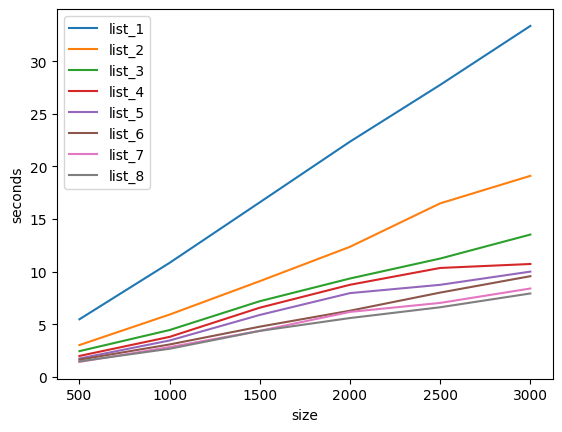

In [106]:
perf_df.plot(x="size", y=[f"list_{n}" for n in range(1,9)], ylabel="seconds")


<Axes: xlabel='pool_size', ylabel='seconds'>

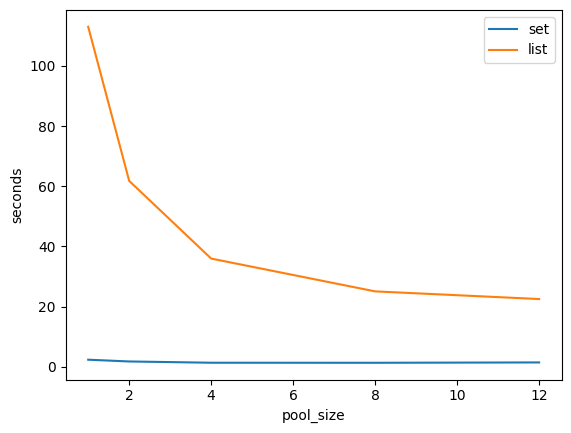

In [107]:
perf_pool_df.plot(x="pool_size", y=["set", "list"], ylabel="seconds")
